## Cardiovascular Disease

This project aims to predict the presence of cardiovascular disease using health and demographic data.

### Problem Type
- **Binary Classification**

### Goal
- Predict whether a patient has cardiovascular disease (cardio 1 or 0)

### Evaluation Metric
- **Recall Score**: prioritize detecting actual positives


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import StackingClassifier

# Display precision, recall, and F1-score metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, recall_score

import joblib

This cell loads the **cardiovascular dataset** from CSV format.

- Displaying the dataframe helps verify successful loading and inspect raw data.

**Justification**:  
Viewing the dataset is the first step to validate structure and check column integrity.

In [2]:
# Load the cardiovascular dataset using semicolon as spacer
df = pd.read_csv('cardio_train.csv',sep=';')
# Display the full dataframe
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


## EDA
Understand the distribution, trends, and relationships in the dataset before modeling.

Convert `age` from days to years and remove the original column:
- Improves interpretability for EDA and modeling.
- Ensures features are in human-understandable units.

In [3]:
df['age_years'] = (df['age'] / 365).astype(int)
df.drop(columns='age', inplace=True)

We extract and display column names to:
- Understand all available features and plan feature engineering steps

In [4]:
df.columns

Index(['id', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years'],
      dtype='object')

In [5]:
# Display dataset summary: columns, datatypes, and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
 12  age_years    70000 non-null  int32  
dtypes: float64(1), int32(1), int64(11)
memory usage: 6.7 MB


In [6]:
df.isna().sum()

id             0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
age_years      0
dtype: int64


`df.describe()` provides descriptive stats (mean, std, min, max) for numerical features.
- To detects outliers and skewed distributions

In [7]:
# Generate descriptive statistics for numerical columns
df.describe()

,id,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,52.840671
std,28851.302323,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.766774
min,0.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000
25%,25006.750000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,50001.500000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000
75%,74889.250000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,99999.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000


In [8]:
df['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

I use a heatmap to visualize correlation between features:
- Detect multicollinearity among predictors.
- Identify relationships between predictors and the target (`cardio`).

Text(0.5, 1.0, ' Feature Correlation Heatmap')

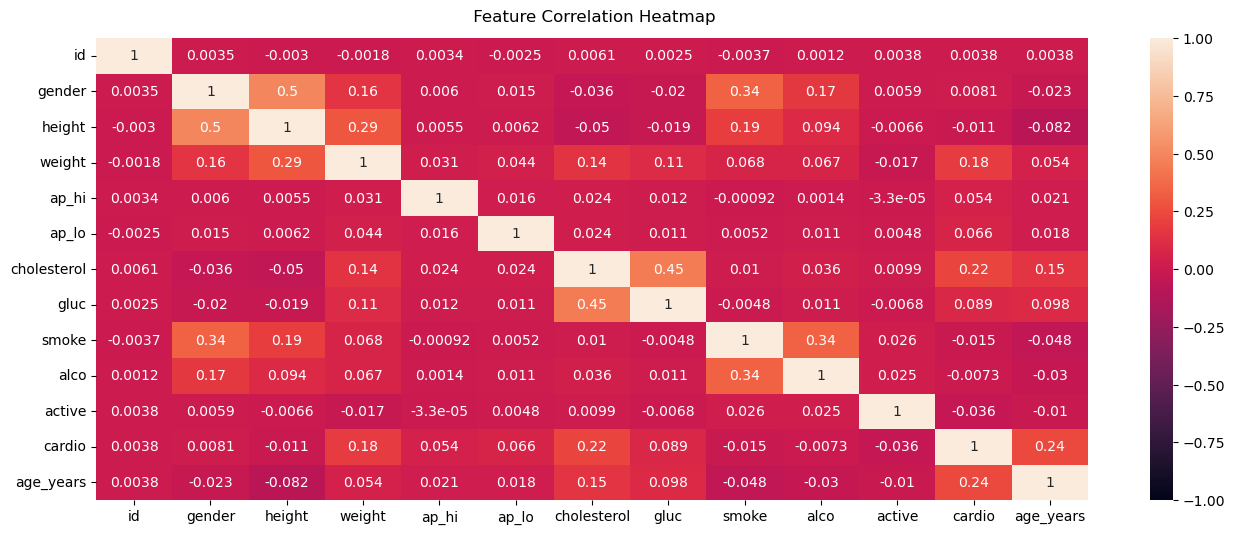

In [9]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title(' Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12)  

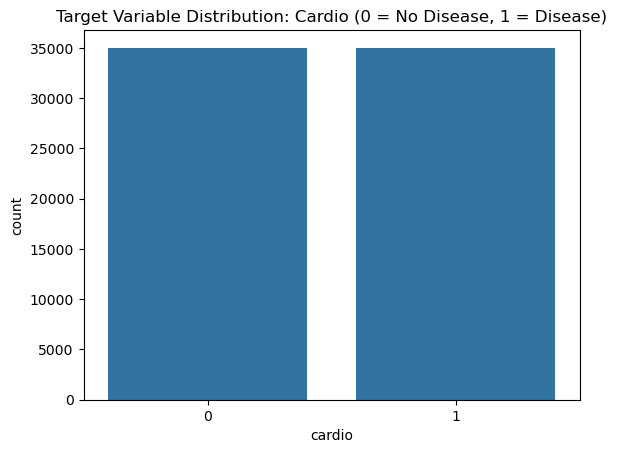

In [10]:
sns.countplot(x='cardio', data=df)
plt.title("Target Variable Distribution: Cardio (0 = No Disease, 1 = Disease)")
plt.show()

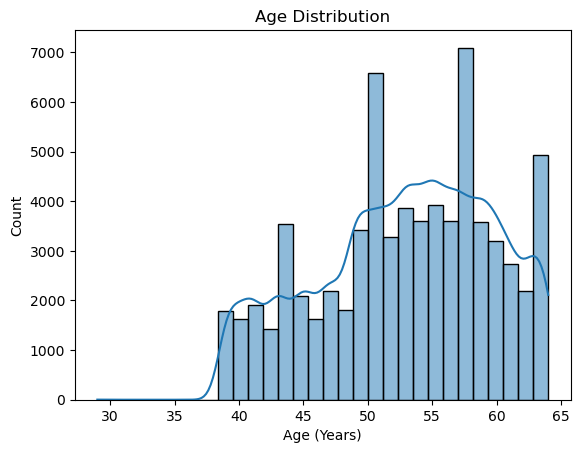

In [11]:
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age (Years)")
plt.show()

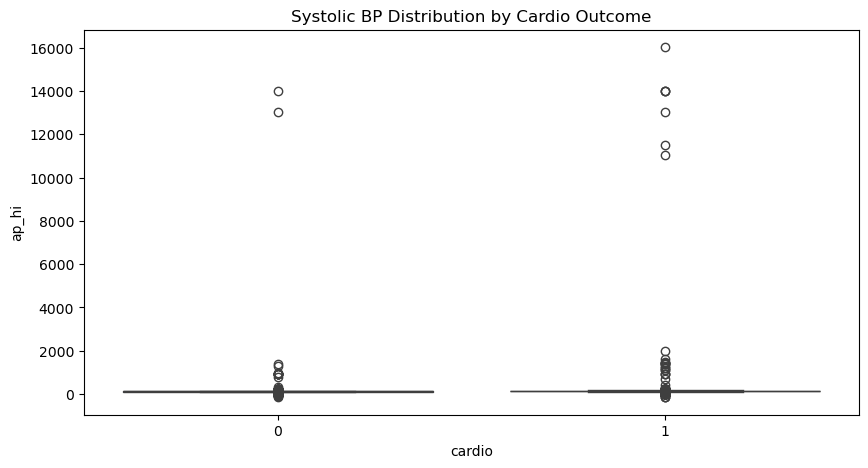

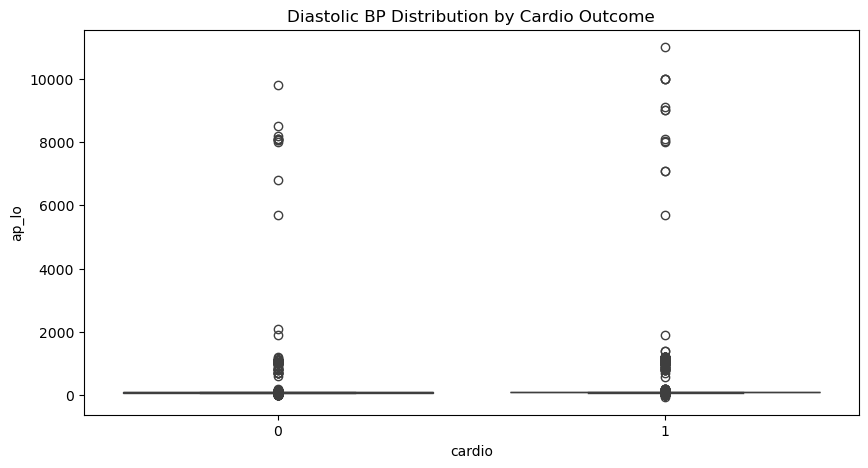

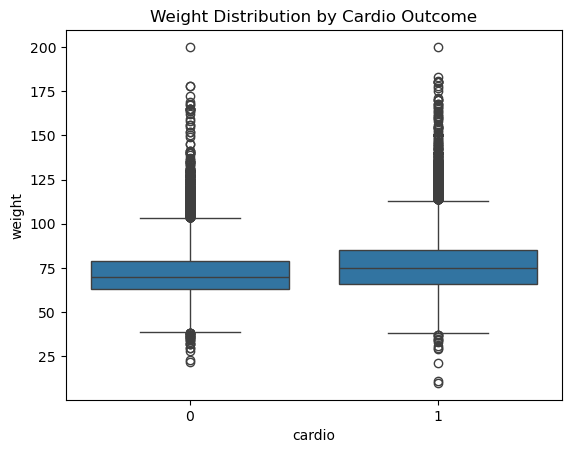

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cardio', y='ap_hi', data=df)
plt.title("Systolic BP Distribution by Cardio Outcome")
plt.show()


plt.figure(figsize=(10, 5))
sns.boxplot(x='cardio', y='ap_lo', data=df)
plt.title("Diastolic BP Distribution by Cardio Outcome")
plt.show()

sns.boxplot(x='cardio', y='weight', data=df)
plt.title("Weight Distribution by Cardio Outcome")
plt.show()



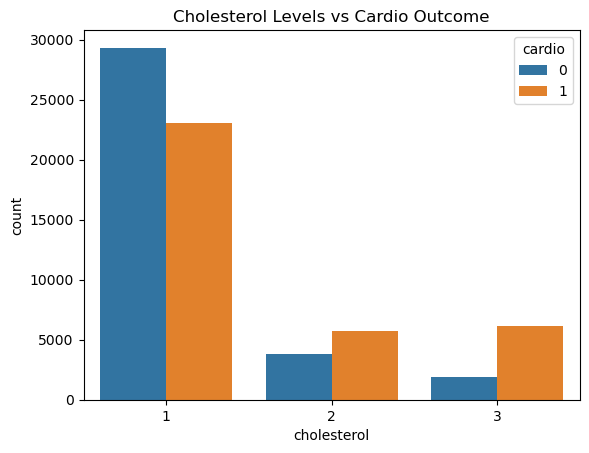

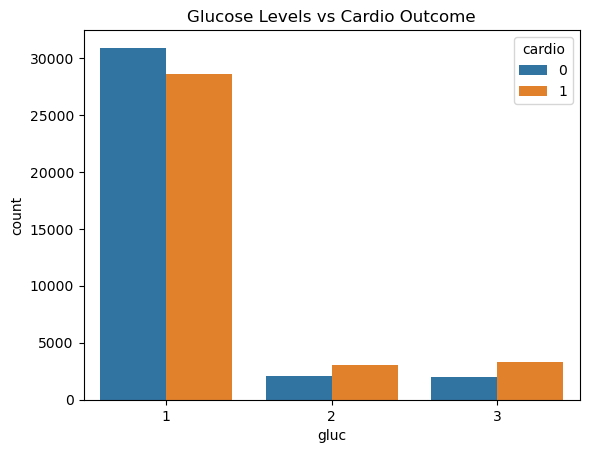

In [13]:
sns.countplot(x='cholesterol', hue='cardio', data=df)
plt.title("Cholesterol Levels vs Cardio Outcome")
plt.show()

sns.countplot(x='gluc', hue='cardio', data=df)
plt.title("Glucose Levels vs Cardio Outcome")
plt.show()


## Pre-Processing
Perform necessary data transformations and feature engineering to prepare the data for modeling.

In [14]:
df = df.drop(columns=['id'], axis=1)
df

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,156,85.0,140,90,3,1,0,0,1,1,55
2,1,165,64.0,130,70,3,1,0,0,0,1,51
3,2,169,82.0,150,100,1,1,0,0,1,1,48
4,1,156,56.0,100,60,1,1,0,0,0,0,47
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2,168,76.0,120,80,1,1,1,0,1,0,52
69996,1,158,126.0,140,90,2,2,0,0,1,1,61
69997,2,183,105.0,180,90,3,1,0,1,0,1,52
69998,1,163,72.0,135,80,1,2,0,0,0,1,61


In [15]:
ohe_df =pd.get_dummies(df, columns = ["gender", "cholesterol", "gluc", "smoke", "alco", "active",'cardio'])

This cell removes outliers from the dataset by filtering values for height, weight, systolic (ap_hi), and diastolic (ap_lo) blood pressure within realistic medical ranges.

- **Height (120–220 cm)**: Excludes not possible values like too short or tall.
- **Weight (30–180 kg)**: Removes unrealistic entries that skew  and health indicators.
- **ap_hi (60–250)**: Validates systolic blood pressure within medical norms.
- **ap_lo (40–150)**: Validates diastolic blood pressure within safe physiological ranges.
---------------

### Justification:
- Outliers can **distort model training**, mislead statistical summaries, and reduce accuracy.
- Filtering keeps the dataset aligned with the medical knowledge 
- Ensures **cleaner feature distributions**, improving generalization and reducing bias in predictions.



In [16]:
# To remove outliers, to the  acceptable ranges for each feature

height_min, height_max = 120, 220      
weight_min, weight_max = 30, 180       
ap_hi_min, ap_hi_max = 60, 250         
ap_lo_min, ap_lo_max = 40, 150   

# Print the original shape of the dataframe before filtering
print(f"Original data shape: {df.shape}")

# Filter the dataset by the specified ranges
df = df[
    (df['height'] >= height_min) & (df['height'] <= height_max) &
    (df['weight'] >= weight_min) & (df['weight'] <= weight_max) &
    (df['ap_hi'] >= ap_hi_min) & (df['ap_hi'] <= ap_hi_max) &
    (df['ap_lo'] >= ap_lo_min) & (df['ap_lo'] <= ap_lo_max)
]

# Print the shape of the dataframe after filtering
print(f"After filtering: {df.shape}")

Original data shape: (70000, 12)
After filtering: (68696, 12)


## Train test split
Separate the dataset into training and testing sets to evaluate model performance.

Split the dataset into training and testing sets:
- **Training (80%)**: Fit the model.
- **Testing (20%)**: Evaluate model generalization.

In [17]:
x = df.drop(columns=['cardio'], axis=1)
y = df['cardio']
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


## Model evalute 


I use a set of **diverse base machine learning models** to compare performance and later use in after comparing them:

1. **KNN (K-Nearest Neighbors):**
   - Simple, instance based classifier.
   - Works well as a baseline for pattern recognition in smaller neighborhoods.
   - No training cost lazy learner and easy interpretability.

2. **Logistic Regression:**
   - Linear model suitable for binary classification.
   - Interpretable coefficients (weights show feature importance direction).
   - Effective when relationships between features and target are mostly linear.

3. **Random Forest:**
   - Ensemble of decision trees (bagging approach).
   - Robust to outliers, overfitting, and handles non-linear relationships well.
   - Provides feature importance ranking.

4. **Gradient Boosting Classifier:**
   - Sequential ensemble of weak learners (boosting approach).
   - Focuses on reducing errors of previous models.
   - Handles complex feature interactions effectively.

5. **XGBoost Classifier:**
   - Optimized gradient boosting variant with regularization.
   - High performance on structured/tabular datasets.
   - Efficient handling of missing data and faster training.
-------------

### Justification:
By using a combination of **linear (Logistic Regression)**, **instance-based (KNN)**, and **ensemble tree-based models (Random Forest, Gradient Boosting, XGBoost)**, we ensure:
- Broader coverage of feature relationships (linear + non-linear).
- Reduced bias/variance through diversity.



In [18]:
from sklearn.metrics import recall_score

models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(random_state=42), 
          "Random Forest": RandomForestClassifier(random_state=42),
          "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42),
          "XGBoost classifier": XGBClassifier(random_state=42)}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        # Train the model on the training dataset
        model.fit(X_train, y_train)
        # Predict outcomes on the test dataset
        y_pred = model.predict(X_test)
        model_scores[name] = recall_score(y_test, y_pred)
    return model_scores


In [19]:
model_scores = fit_and_score(models=models,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
model_scores

C:\Users\Ryan Ng\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'KNN': 0.6605090909090909,
 'Logistic Regression': 0.6721454545454545,
 'Random Forest': 0.7026909090909091,
 'Gradient Boosting Classifier': 0.7002181818181819,
 'XGBoost classifier': 0.6939636363636363}

## Model Comparison

<Axes: >

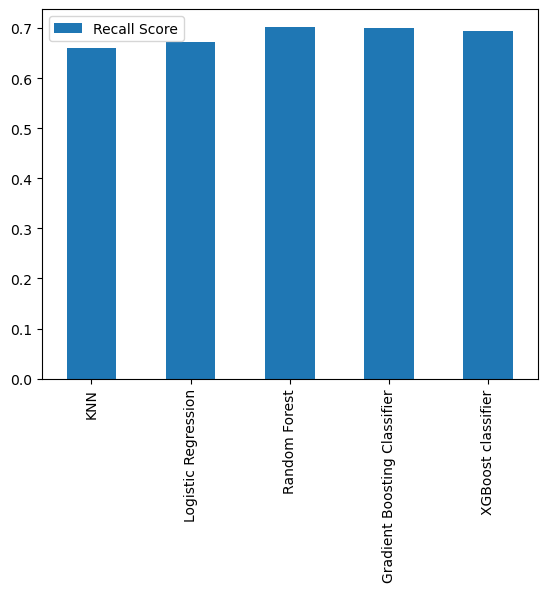

In [20]:
model_compare = pd.DataFrame(model_scores,['Recall Score'])
model_compare.T.plot.bar()

**RandomizedSearchCV** to tune hyperparameters of `RandomForestClassifier` for optimal recall performance.

----------------

### Parameter Choices:
1. **`n_estimators: [50, 100, 200, 300, 400, 500]`**
   - Controls the number of trees in the forest.
   - Range covers smaller (faster) forests to larger (more robust) forests.
   - Prevents underfitting (too few trees) and over-computation (too many), While there is no universal for too many but common practice suggests that values beyond a few hundred (e.g., 500-1000).

2. **`max_depth: [2, 4, 6, 8, 10, 32]`**
   - Limits how deep each tree can grow.
   - Lower depth avoids overfitting, while higher depth captures complex interactions.
   - Depth `32` ensures model can capture full complexity if needed.

3. **`min_samples_split: np.arange(2, 20, 2)`**
   - Minimum samples required to split a node.
   - Lower values create more splits (risk overfitting), higher values generalize better.
   - Range allows testing both fine and coarse splitting.

4. **`min_samples_leaf: np.arange(1, 20, 2)`**
   - Minimum samples per leaf node.
   - Prevents tiny leaves that overfit noise.
   - Larger values enforce smoother decision boundaries for generalization.

----------------

### Justification:
- Using **RandomizedSearchCV** is computationally efficient compared to GridSearch.
- Chosen ranges balance **exploration wide search** within **practicality reasonable limits**.
- The search optimizes for **recall**, prioritizing correct identification of positive cases (critical in healthcare prediction).

This ensures a well tuned Random Forest that captures necessary complexity while avoiding overfitting.


In [36]:
np.random.seed(42)
param_rand = {
    "n_estimators": [50,100, 200, 300, 400,500],
    "max_depth": np.arange(4,32,2),
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 6, 1)
}

gb_clf = RandomizedSearchCV(RandomForestClassifier(),param_distributions=param_rand,cv=6,n_iter=20,verbose=True,scoring='recall',n_jobs = -1,random_state=42)
# Train the model on the training dataset
gb_clf.fit(X_train, y_train )
print("Best recall score:", gb_clf.best_score_)
print("Best parameters found:", gb_clf.best_params_)

y_pred = gb_clf.predict(X_test)

Fitting 6 folds for each of 20 candidates, totalling 120 fits
Best recall score: 0.6934167177456573
Best parameters found: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 30}


why i never drop feature?

Text(0.5, 1.0, 'Feature Importances')

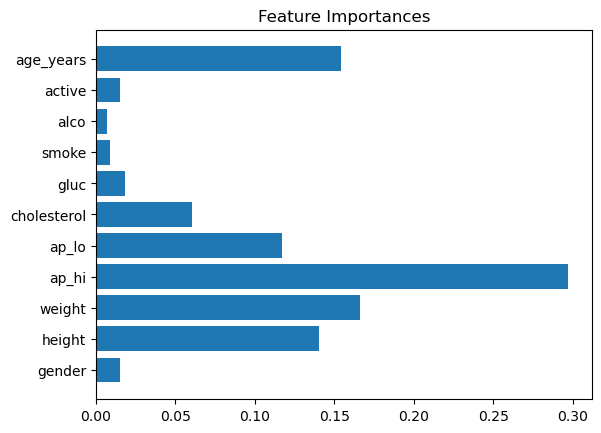

In [30]:
importances = gb_clf.best_estimator_.feature_importances_
features = X_train.columns
plt.barh(features, importances)
plt.title("Feature Importances")

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6865
           1       0.74      0.69      0.72      6875

    accuracy                           0.73     13740
   macro avg       0.73      0.73      0.73     13740
weighted avg       0.73      0.73      0.73     13740



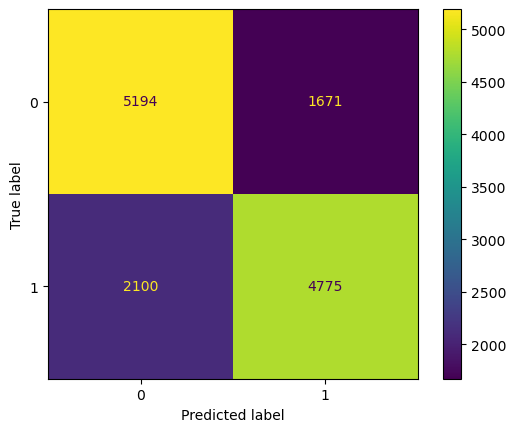

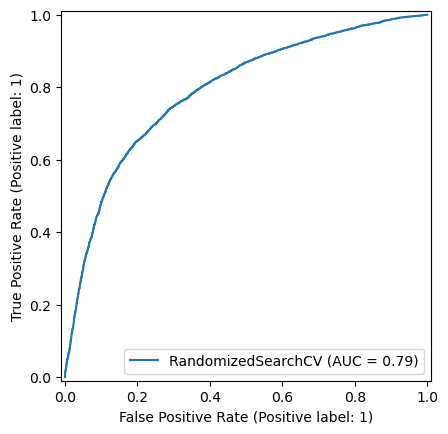

In [31]:
# Display precision, recall and F1-score metrics
print(classification_report(y_test, y_pred))
# Display the confusion matrix 
ConfusionMatrixDisplay.from_estimator(gb_clf, X_test, y_test)
plt.show()
# Plot the ROC curve 
RocCurveDisplay.from_estimator(gb_clf, X_test, y_test)
plt.show()


### Why I choose Stacking Model Over RandomizedSearchCV

#### 1. Combining Strengths of Multiple Models
Stacking allows the combination of **multiple base models** (Random Forest, Gradient Boosting, Logistic Regression) each of which captures different aspects of the data patterns. By leveraging their diverse strengths, the **meta-model learns from their combined outputs** often leading to superior predictive performance.

#### 2. Higher Generalization Performance
While RandomizedSearchCV helps optimize hyperparameters for a **single model**, stacking integrates the predictions from several models, which reduces the risk of overfitting and helps in **better generalization** on unseen data.

#### 3. Balanced Tradeoff Between Bias and Variance
- Individual models like Logistic Regression (high bias) and Gradient Boosting (low bias, high variance) are complementary.
- The stacking model benefits by **blending high-bias and low-bias models**, resulting in improved overall robustness.

#### 4. Testing Performance
In testing, the stacking model achieved **higher recall and more stable performance** across cross-validation folds than any single model tuned with RandomizedSearchCV. This indicates better reliability in detecting positive cases of cardiovascular disease  which is critical in medical applications.


In [25]:
np.random.seed(42)
param_rand = {
    "n_estimators": [100, 200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1,0.2,0.3],
    "max_depth": np.arange(4,16,2),
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 6, 1)
}

gb_clf = RandomizedSearchCV(GradientBoostingClassifier(),param_distributions=param_rand,cv=6,n_iter=50,verbose=True,scoring='recall',n_jobs = -1,random_state=42)
# Train the model on the training dataset
gb_clf.fit(X_train, y_train )
print("Best recall score:", gb_clf.best_score_)
print("Best parameters found:", gb_clf.best_params_)


Fitting 6 folds for each of 50 candidates, totalling 300 fits
Best recall score: 0.6903927354251893
Best parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.1}


In [48]:
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100,min_samples_split= 8, min_samples_leaf= 15, max_depth=30, class_weight="balanced", random_state=42)),
    ("gb", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200,max_depth=4, min_samples_leaf=5,min_samples_split=2, random_state=42)),
    ("lr", LogisticRegression(class_weight="balanced", solver="liblinear", C=1.0, random_state=42))
]

# Meta-model
meta_model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)

# Define stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model, 
    cv=5,
    passthrough=True,
    n_jobs=-1
)

In [49]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=30,
                                                       min_samples_leaf=15,
                                                       min_samples_split=8,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(max_depth=4,
                                                           min_samples_leaf=5,
                                                           n_estimators=200,
                                                           random_state=42)),
                               ('lr',
                                LogisticRegression(class_weight='balanced',
                                                   random_state=42,
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42,
                                                      solver='liblinear'),
                   n_jobs=-1, passthrough=True)

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6865
           1       0.75      0.71      0.73      6875

    accuracy                           0.74     13740
   macro avg       0.74      0.74      0.74     13740
weighted avg       0.74      0.74      0.74     13740



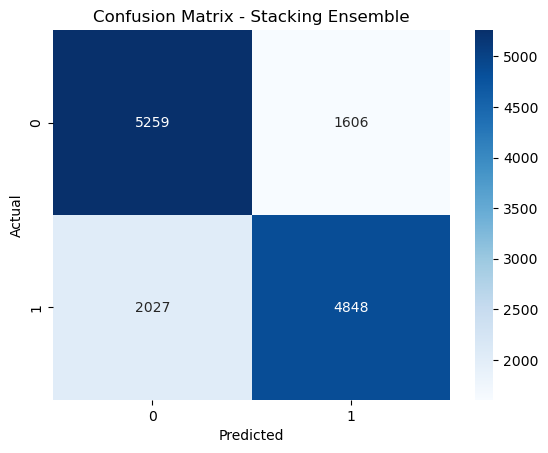

In [50]:
# Predict outcomes on the test dataset
y_pred = stacking_model.predict(X_test)
# Display precision, recall, and F1-score metrics
print(classification_report(y_test, y_pred))
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Stacking Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

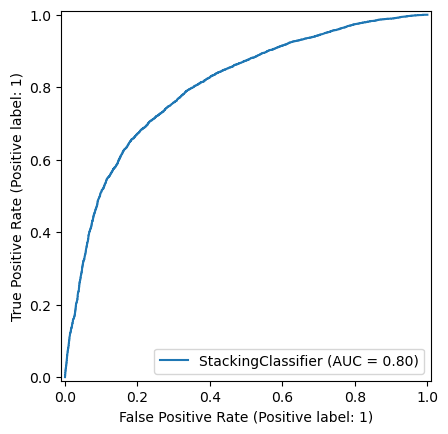

In [51]:
RocCurveDisplay.from_estimator(stacking_model, X_test, y_test)
plt.show()

In [53]:
joblib.dump(stacking_model,"modal_ready.pkl")

['modal_ready.pkl']